## Here we will be loading the wind experiment and then recalculate correlatins
## EASTERLIES

### Good examples to follow
#### - https://github.com/adele157/easterlies-collaborative-project/blob/master/notebooks/example_notebook.ipynb
#### - https://github.com/adele157/easterlies-collaborative-project/blob/master/notebooks/figures/Figure-8.ipynb


In [17]:
import cmocean 
import cosima_cookbook as cc
import dask.distributed as dsk
import gsw
import glob
import matplotlib.gridspec as gs
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import xarray as xr

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

from dask.distributed import Client

figdir = '/g/data/jk72/ns3783'

clnt = dsk.Client()
clnt

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/39365/status,
Dashboard: /proxy/39365/status,Workers: 1
Total threads: 1,Total memory: 100.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37811,Workers: 1
Dashboard: /proxy/39365/status,Total threads: 1
Started: Just now,Total memory: 100.00 GiB
Comm: tcp://127.0.0.1:42885,Total threads: 1
Dashboard: /proxy/41637/status,Memory: 100.00 GiB
Nanny: tcp://127.0.0.1:35625,


#### Load different datasets and expreiments

In [18]:
#session_ryf = cc.database.create_session()
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

experiment_eup = '01deg_jra55v13_ryf9091_easterlies_up10'
experiment_edo = '01deg_jra55v13_ryf9091_easterlies_down10'
easterlies_up_zonal = '01deg_jra55v13_ryf9091_easterlies_up10_zonal'
easterlies_up_meridional = '01deg_jra55v13_ryf9091_easterlies_up10_meridional'
#easterlies_up_noDSW = '01deg_jra55v13_ryf9091_easterlies_up10_noDSW'


# plot anomalies for last 5 years of simulation:
start_time='2150-01-01'   #try with 2150 again?
end_time='2159-12-31'


In [19]:
#cc.querying.get_experiments(easterlies_session)

In [20]:
depth_slice = slice(400, 6000)
#lat_slice  = slice(-79,-59)
lon_slice  = slice(-252.7, -251.7)
lat_slice  = slice(-65.35, -65.1)

temp_con = cc.querying.getvar(control,'temp', master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_con = temp_con.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=depth_slice)                             
temp_con = temp_con.load()

# temp_up = cc.querying.getvar(easterlies_up_meridional,'temp',master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
# temp_upY = temp_up.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=depth_slice)                      
# temp_upY = temp_upY.load()

temp_up = cc.querying.getvar(experiment_edo,'temp',master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_upY = temp_up.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=depth_slice)                      
temp_upY = temp_upY.load()

temp_up = cc.querying.getvar(easterlies_up_zonal,'temp', master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_upX = temp_up.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=depth_slice)                           
temp_upX = temp_upX.load()

Exception during reset or similar
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/sqlalchemy/pool/base.py", line 697, in _finalize_fairy
    fairy._reset(pool)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/sqlalchemy/pool/base.py", line 893, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/sqlalchemy/engine/default.py", line 558, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 22550490392384 and this is thread id 22547211216640.
Exception closing connection <sqlite3.Connection object at 0x1481ce28c8a0>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/sqlalchemy/pool/b

In [21]:
# depth average:
# there is no dzu saved
# calculate grid thickness, adjusted for partial cells:
zlevel1 = 400
zlevel2 = 6000

# import edges of st_ocean and add lat/lon dimensions:
st_edges_ocean = cc.querying.getvar(control,'st_edges_ocean',master_session,
                 start_time=start_time, end_time=end_time,n=1)
st_edges_array = st_edges_ocean.expand_dims({'yt_ocean':temp_con.yt_ocean,'xt_ocean':temp_con.xt_ocean},axis=[1,2])
# import bathymetry:
ht = cc.querying.getvar(control,'ht',master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
# adjust edges at bottom for partial thickness:
st_edges_with_partial = st_edges_array.where(st_edges_array<ht,other=ht)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = cc.querying.getvar(control,'st_ocean',master_session,n=1)
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean':'st_ocean'}))

# select correct depths:
thickness = thickness.sel(st_ocean=slice(zlevel1,zlevel2))

# multiply by thickness to avg
temp_con = (temp_con*thickness).sum('st_ocean')/thickness.sum('st_ocean')
temp_upX = (temp_upX*thickness).sum('st_ocean')/thickness.sum('st_ocean')
temp_upY = (temp_upY*thickness).sum('st_ocean')/thickness.sum('st_ocean')


In [22]:
#temp_upX

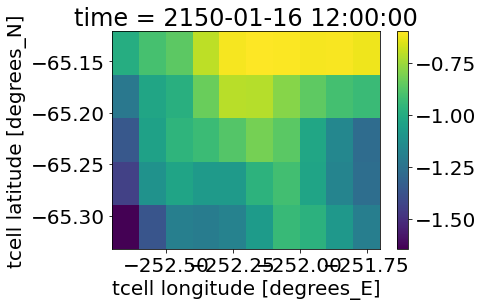

In [23]:
##test if temp is still working after the depth weighting
temp_upY[0,...].plot()
#temp_upY.plot()

In [24]:
#AREA WEIGHTING #area t cant be found at iaf_cycle3
# area weighting:
area_t = cc.querying.getvar(control,'area_t',master_session, ncfile = 'ocean_grid.nc',n=-1)
area_t = area_t.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

# sum area:
area_t_sum = area_t.sum('xt_ocean').sum('yt_ocean')

# Apply area weight:
temp_con = (temp_con*area_t).sum('xt_ocean').sum('yt_ocean')/area_t_sum
temp_upX = (temp_upX*area_t).sum('xt_ocean').sum('yt_ocean')/area_t_sum
temp_upY = (temp_upY*area_t).sum('xt_ocean').sum('yt_ocean')/area_t_sum

In [25]:
temp_upY

<xarray.DataArray (time: 120)>
dask.array<truediv, shape=(120,), dtype=float64, chunksize=(120,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2150-01-16 12:00:00 ... 2159-12-16 12:00:00

In [26]:
temp_con = temp_con.load()
temp_upX = temp_upX.load()
temp_upY = temp_upY.load()

### Make a time series just for testing, no detrending or roll mean

In [27]:
temp_con_a = temp_con.groupby('time.year').mean(dim='time')
temp_con_a = temp_con_a.load()

temp_upX_a = temp_upX.groupby('time.year').mean(dim='time')
temp_upX_a = temp_upX_a.load()

temp_upY_a = temp_upY.groupby('time.year').mean(dim='time')
temp_upY_a = temp_upY_a.load()

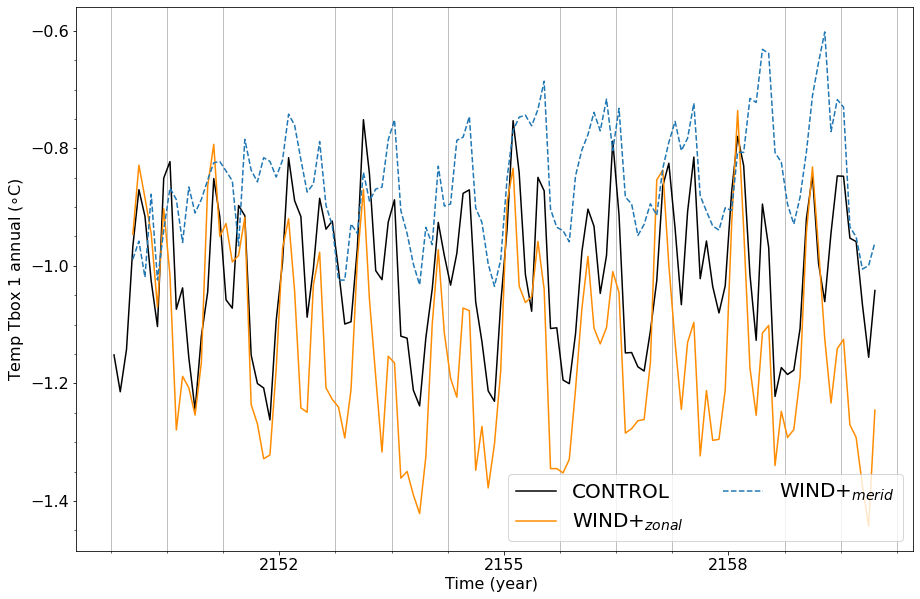

In [28]:
#Confirming the peaks and lows by plotting the year mean
fontsize=16

plt.figure(figsize=(15,10))

temp_con.plot(color='k',label = 'CONTROL')
temp_upX.plot(color='darkorange', label = 'WIND+$_{zonal}$')
temp_upY.plot(color='C0', linestyle = '--', label = 'WIND+$_{merid}$')
plt.ylabel('Temp Tbox 1 annual ($\circ$C)', fontsize=fontsize, color='k')
plt.xlabel(r'Time (year) ', fontsize = fontsize)
plt.tick_params(axis='x',labelsize=fontsize)
plt.tick_params(axis='y', labelcolor='k',labelsize=fontsize)
#plt.xlim(2160,2164)

#this is so i can see minor ticks to aid in counting years
plt.locator_params(axis='x', nbins=5)
plt.minorticks_on()
plt.grid(axis='x',which='minor')
plt.tick_params(axis='y', which='minor', bottom=False) #turns of minor ticks on x

plt.legend(ncol = 2, loc = 'lower right')

#save_results_to = '/g/data/jk72/ns3783/Round 10'
#plt.savefig(save_results_to + 'temp_series_test_EExp.png', dpi=120,bbox_inches='tight', pad_inches=0.1)

### LOAD ASC HEAT TRANSPORT ZONAL

### LOAD ASC SPEED

### LOAD ISOPYCNAL DEPTH

In [47]:
# load temperature data at 200m (defined on transect):
lat_slice  = slice(-75.5,-60)
lon_slice  = slice(-256, -247)

temp_iso = cc.querying.getvar(control,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_iso = temp_iso.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
temp_iso = temp_iso.load()

temp_iso_upX = cc.querying.getvar(easterlies_up_zonal,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_iso_upX = temp_iso_upX.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
temp_iso_upX = temp_iso_upX.load()

temp_iso_upY = cc.querying.getvar(easterlies_up_meridional,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_iso_upY = temp_iso_upY.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
temp_iso_upY = temp_iso_upY.load()

sal_iso = cc.querying.getvar(control,'salt' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
sal_iso = sal_iso.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
sal_iso = sal_iso.load()

sal_iso_upX = cc.querying.getvar(easterlies_up_zonal,'salt' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
sal_iso_upX = sal_iso_upX.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
sal_iso_upX = sal_iso_upX.load()

sal_iso_upY = cc.querying.getvar(easterlies_up_meridional,'salt' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
sal_iso_upY = sal_iso_upY.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
sal_iso_upY = sal_iso_upY.load()


distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

In [48]:
# calculate density along transect:
# arrays for gsw to use
depth_array = temp_iso*0 + temp_iso.st_ocean
lat_array = temp_iso*0 + temp_iso.yt_ocean
# need to convert practical salinity to absolute salinity:
pressure = gsw.p_from_z(-depth_array,lat_array)
# need to convert practical salinity to absolute salinity:
salt_abs = gsw.SA_from_SP(sal_iso,pressure,sal_iso.xt_ocean,lat_array)
#calculate sigma
sigma0 = gsw.sigma0(salt_abs,temp_iso)

# calculate density along transect:
# arrays for gsw to use
depth_array_upX = temp_iso_upX*0 + temp_iso_upX.st_ocean
lat_array_upX = temp_iso_upX*0 + temp_iso_upX.yt_ocean
# need to convert practical salinity to absolute salinity:
pressure_upX = gsw.p_from_z(-depth_array_upX,lat_array_upX)
# need to convert practical salinity to absolute salinity:
salt_abs_upX = gsw.SA_from_SP(sal_iso_upX,pressure_upX,sal_iso_upX.xt_ocean,lat_array_upX)
#calculate sigma
sigma0_upX = gsw.sigma0(salt_abs_upX,temp_iso_upX)


# calculate density along transect:
# arrays for gsw to use
depth_array_upY = temp_iso_upY*0 + temp_iso_upY.st_ocean
lat_array_upY = temp_iso_upY*0 + temp_iso_upY.yt_ocean
# need to convert practical salinity to absolute salinity:
pressure_upY = gsw.p_from_z(-depth_array_upY,lat_array_upY)
# need to convert practical salinity to absolute salinity:
salt_abs_upY = gsw.SA_from_SP(sal_iso_upY,pressure_upY,sal_iso_upY.xt_ocean,lat_array_upY)
#calculate sigma
sigma0_upY = gsw.sigma0(salt_abs_upY,temp_iso_upY)


In [49]:
rho_thresh = 27.82

# mask density where < rho_thresh:
sigma0_off_mask = sigma0.where(sigma0>rho_thresh)
# check this worked:
#sigma0_off_mask[0,:,:,0].plot()

# Now find first depth where sigma0_off_mask is not masked:
depth_array = sigma0*0 + sigma0.st_ocean
# mask depth array using density threshold:
depth_array_masked = depth_array.where(sigma0>rho_thresh)
# find minimum depth at each lat,lon location:
min_depth = depth_array_masked.min(dim='st_ocean')

#rename the isopycnal
iso2782_dth=min_depth



# mask density where < rho_thresh:
sigma0_off_mask_upX = sigma0_upX.where(sigma0_upX>rho_thresh)
# check this worked:
#sigma0_off_mask[0,:,:,0].plot()

# Now find first depth where sigma0_off_mask is not masked:
depth_array_upX = sigma0_upX*0 + sigma0_upX.st_ocean
# mask depth array using density threshold:
depth_array_masked_upX = depth_array_upX.where(sigma0_upX>rho_thresh)
# find minimum depth at each lat,lon location:
min_depth_upX = depth_array_masked_upX.min(dim='st_ocean')

#rename the isopycnal
iso2782_dth_upX=min_depth_upX


# mask density where < rho_thresh:
sigma0_off_mask_upY = sigma0_upY.where(sigma0_upY>rho_thresh)
# check this worked:
#sigma0_off_mask[0,:,:,0].plot()

# Now find first depth where sigma0_off_mask is not masked:
depth_array_upY = sigma0_upY*0 + sigma0_upY.st_ocean
# mask depth array using density threshold:
depth_array_masked_upY = depth_array_upY.where(sigma0_upY>rho_thresh)
# find minimum depth at each lat,lon location:
min_depth_upY = depth_array_masked_upY.min(dim='st_ocean')

#rename the isopycnal
iso2782_dth_upY=min_depth_upY

In [50]:
isocon = iso2782_dth.load()
isocon_upX = iso2782_dth_upX.load()
isocon_upY = iso2782_dth_upY.load()

##### Cut data loaded on previously, so we don't have t load it again

In [51]:
# cut the data BOX 1
lon_slice  = slice(-253, -251.5)
lat_slice  = slice(-67.5, -63)

# topography data:
ht = cc.querying.getvar(control,'ht', master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

fontsize=16

##### MAKE MASK FOR BOX 1 offshore in between 1000 and 2000 isopycnals

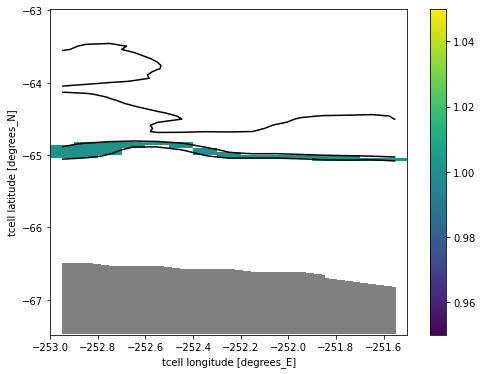

In [52]:
# Mask 

# set to 1 everywhere:
region_mask = ht*0 +1

# mask open ocean:
# shelf masking:
contour_file = np.load('/g/data/jk72/ns3783/Antarctic_slope_contour_10002000m.npz')
shelf_mask = contour_file['temp_mask']
yt_ocean = contour_file['yt_ocean']
xt_ocean = contour_file['xt_ocean']
# Mask values that are non-zero
shelf_mask[np.where(shelf_mask!=0)] = np.nan
shelf_mask = shelf_mask+1
shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])

region_mask = region_mask * shelf_mask.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)


plt.figure(figsize=(8,6))
region_mask.plot()
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,[1000,2000,3000],colors='k')
#plt.xlim(-275,-245)
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')

In [53]:
#apply the mask iso 82
isocon_off = isocon*region_mask
isocon_off = isocon_off.where(isocon_off!=0)

#apply the mask iso 82
isocon_offX = isocon_upX*region_mask
isocon_offX = isocon_offX.where(isocon_offX!=0)

#apply the mask iso 82
isocon_offY = isocon_upY*region_mask
isocon_offY = isocon_offY.where(isocon_offY!=0)

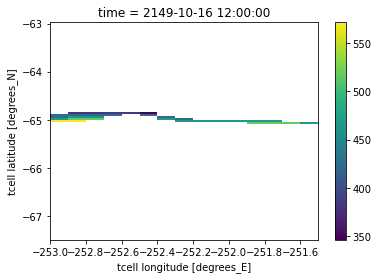

In [54]:
# first time step only:
isocon_off[0,...].plot()

#### Load this new variables to guarantee plots will run smoothly 

In [55]:
isocon_off = isocon_off.load()
isocon_offX = isocon_offX.load()
isocon_offY = isocon_offY.load()

In [56]:
isocon_off = isocon_off.mean('xt_ocean').mean('yt_ocean')
isocon_offX = isocon_offX.mean('xt_ocean').mean('yt_ocean')
isocon_offY = isocon_offY.mean('xt_ocean').mean('yt_ocean')

#try detrending to see if there is something here on this graph that changes


## First run the function to detrend the time series later on 

### Function for doing spatial correlations/regressions:

#### This comes from http://hrishichandanpurkar.blogspot.com/2017/09/vectorized-functions-for-correlation.html


In [57]:
def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n     = x.shape[0]
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)
    
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)
    
    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope  
    
    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats
    
    from scipy.stats import t
    pval   = t.sf(tstats, n-2)*2
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    return cov,cor,slope,intercept,pval,stderr

# detrending function:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

In [58]:
temp_cond = detrend_dim(temp_con,'time')
temp_upXd = detrend_dim(temp_upX,'time')
temp_upYd = detrend_dim(temp_upY,'time')

# asc_uspeed_cond = detrend_dim(asc_uspeed_con,'time')
# asc_uspeed_upXd = detrend_dim(asc_uspeed_upX,'time')
# asc_uspeed_upYd = detrend_dim(asc_uspeed_upY,'time')

# asc_heatx_cond = detrend_dim(asc_heatx_con,'time')
# asc_heatx_upXd = detrend_dim(asc_heatx_upX,'time')
# asc_heatx_upYd = detrend_dim(asc_heatx_upY,'time')

isocon_offd = detrend_dim(isocon_off,'time')
isocon_offXd = detrend_dim(isocon_offX,'time')
isocon_offYd = detrend_dim(isocon_offY,'time')

### Plot

Text(0, 0.5, 'Isopycnal 27.82 (m)')

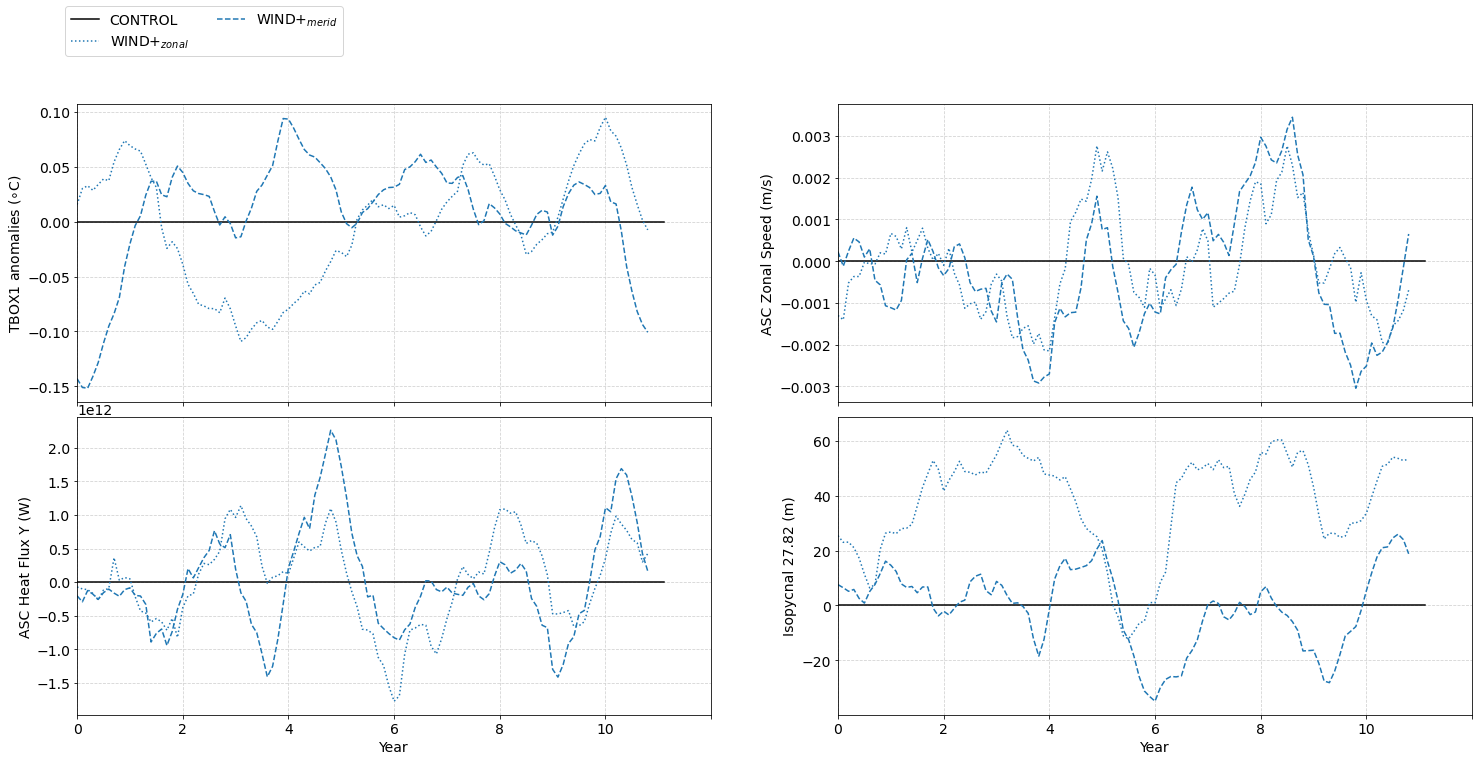

In [38]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (25, 17))
axs = [fig.add_subplot(321), fig.add_subplot(322), fig.add_subplot(323),fig.add_subplot(324)]
plt.subplots_adjust(hspace = 0.05)


axs[0].plot((temp_cond-temp_cond).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'k', label = 'CONTROL')
axs[0].plot((temp_upXd-temp_cond).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'C0', linestyle = ':', label = 'WIND+$_{zonal}$')
axs[0].plot((temp_upYd-temp_cond).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'C0', linestyle = '--', label = 'WIND+$_{merid}$')
    
axs[0].legend(ncol = 2, loc = 'upper center', bbox_to_anchor = (0.2,1.35))

axs[1].plot((asc_uspeed_cond-asc_uspeed_cond).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'k', label = 'CONTROL')
axs[1].plot((asc_uspeed_upXd-asc_uspeed_cond).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'C0', linestyle = ':', label = 'WIND+$_{zonal}$')
axs[1].plot((asc_uspeed_upYd-asc_uspeed_cond).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'C0', linestyle = '--', label = 'WIND+$_{merid}$')

axs[2].plot((asc_heatx_cond-asc_heatx_cond).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'k', label = 'CONTROL')
axs[2].plot((asc_heatx_upXd-asc_heatx_cond).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'C0', linestyle = ':', label = 'WIND+$_{zonal}$')
axs[2].plot((asc_heatx_upYd-asc_heatx_cond).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'C0', linestyle = '--', label = 'WIND+$_{merid}$')

axs[3].plot((isocon_off-isocon_off).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'k', label = 'CONTROL')
axs[3].plot((isocon_offX-isocon_off).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'C0', linestyle = ':', label = 'WIND+$_{zonal}$')
axs[3].plot((isocon_offY-isocon_off).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'C0', linestyle = '--', label = 'WIND+$_{merid}$')

axs[0].set_xlim(0,120)
axs[1].set_xlim(0,120)
axs[2].set_xlim(0,120)
axs[3].set_xlim(0,120)
#axs[2].set_ylim(-1.51, 0.25)

axs[2].set_xticklabels(np.arange(0, 12, 2))
axs[3].set_xticklabels(np.arange(0, 12, 2))
axs[0].set_xticklabels([])
axs[1].set_xticklabels([])
axs[0].grid(linestyle = '--', color = 'lightgrey')
axs[1].grid(linestyle = '--', color = 'lightgrey')
axs[2].grid(linestyle = '--', color = 'lightgrey')
axs[3].grid(linestyle = '--', color = 'lightgrey')
axs[0].set_ylabel('TBOX1 anomalies ($\circ$C)')
axs[2].set_xlabel('Year')
axs[3].set_xlabel('Year')
axs[1].set_ylabel('ASC Zonal Speed (m/s)')
axs[2].set_ylabel('ASC Heat Flux Y (W)')
axs[3].set_ylabel('Isopycnal 27.82 (m)')

#figdir = '/g/data/jk72/ns3783'
#filestr = figdir+'/Figure8.png'
#plt.savefig(filestr,dpi=600,bbox_inches='tight')

In [34]:
#varlist = cc.querying.get_variables(master_session, control)
#varlist[varlist['name'].str.lower().str.match('heat_')]

## Plot 2

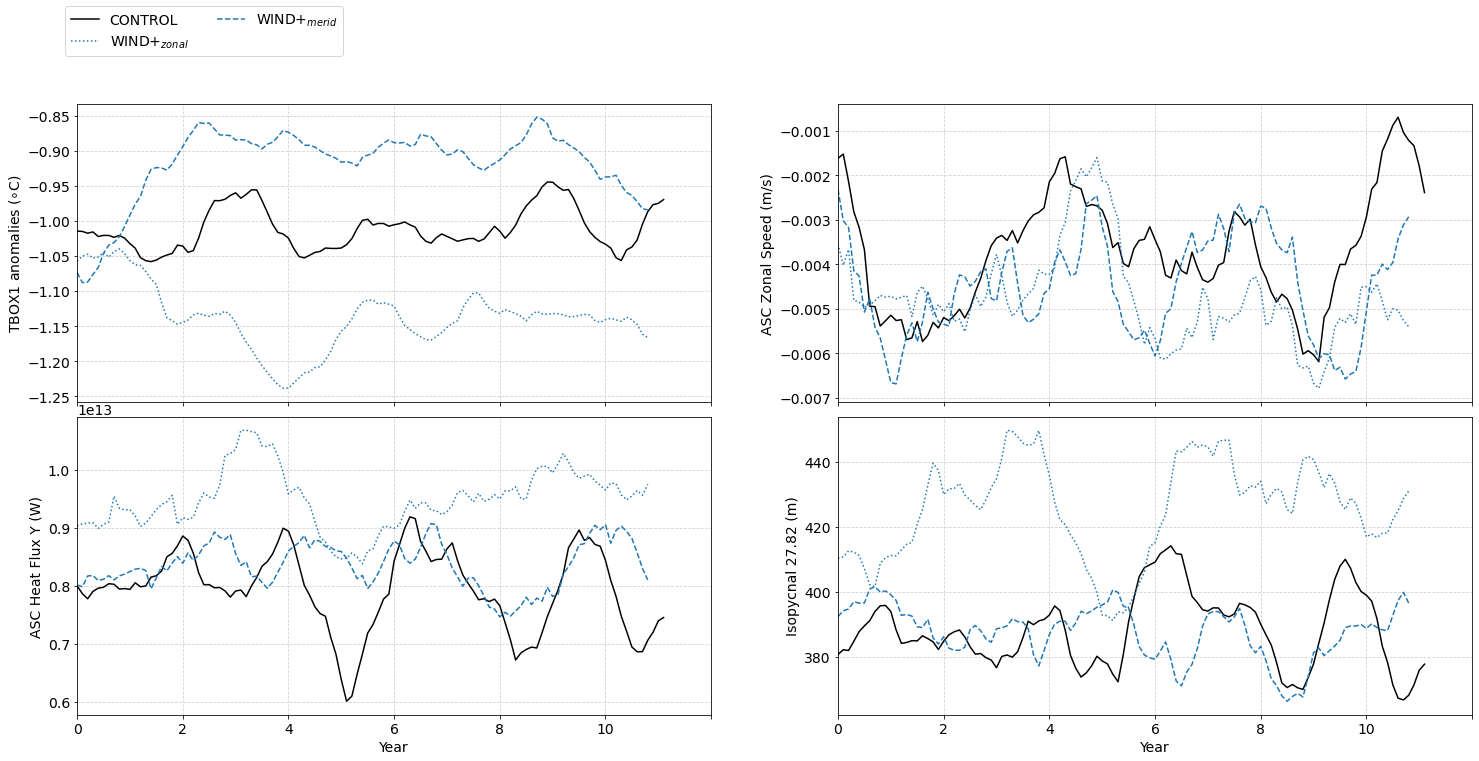

In [43]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (25, 17))
axs = [fig.add_subplot(321), fig.add_subplot(322), fig.add_subplot(323),fig.add_subplot(324)]
plt.subplots_adjust(hspace = 0.05)


axs[0].plot((temp_con).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'k', label = 'CONTROL')
axs[0].plot((temp_upX).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'C0', linestyle = ':', label = 'WIND+$_{zonal}$')
axs[0].plot((temp_upY).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'C0', linestyle = '--', label = 'WIND+$_{merid}$')
    
axs[0].legend(ncol = 2, loc = 'upper center', bbox_to_anchor = (0.2,1.35))

axs[1].plot((asc_uspeed_con).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'k', label = 'CONTROL')
axs[1].plot((asc_uspeed_upX).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'C0', linestyle = ':', label = 'WIND+$_{zonal}$')
axs[1].plot((asc_uspeed_upY).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'C0', linestyle = '--', label = 'WIND+$_{merid}$')

axs[2].plot((asc_heatx_con).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'k', label = 'CONTROL')
axs[2].plot((asc_heatx_upX).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'C0', linestyle = ':', label = 'WIND+$_{zonal}$')
axs[2].plot((asc_heatx_upY).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'C0', linestyle = '--', label = 'WIND+$_{merid}$')

axs[3].plot((isocon_off).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'k', label = 'CONTROL')
axs[3].plot((isocon_offX).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'C0', linestyle = ':', label = 'WIND+$_{zonal}$')
axs[3].plot((isocon_offY).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'C0', linestyle = '--', label = 'WIND+$_{merid}$')

axs[0].set_xlim(0,120)
axs[1].set_xlim(0,120)
axs[2].set_xlim(0,120)
axs[3].set_xlim(0,120)
#axs[2].set_ylim(-1.51, 0.25)

axs[2].set_xticklabels(np.arange(0, 12, 2))
axs[3].set_xticklabels(np.arange(0, 12, 2))
axs[0].set_xticklabels([])
axs[1].set_xticklabels([])
axs[0].grid(linestyle = '--', color = 'lightgrey')
axs[1].grid(linestyle = '--', color = 'lightgrey')
axs[2].grid(linestyle = '--', color = 'lightgrey')
axs[3].grid(linestyle = '--', color = 'lightgrey')
axs[0].set_ylabel('TBOX1 anomalies ($\circ$C)')
axs[2].set_xlabel('Year')
axs[3].set_xlabel('Year')
axs[1].set_ylabel('ASC Zonal Speed (m/s)')
axs[2].set_ylabel('ASC Heat Flux Y (W)')
axs[3].set_ylabel('Isopycnal 27.82 (m)')

figdir = '/g/data/jk72/ns3783'
filestr = figdir+'/Figure8_noanomalia.png'
plt.savefig(filestr,dpi=600,bbox_inches='tight')

## Plot 3

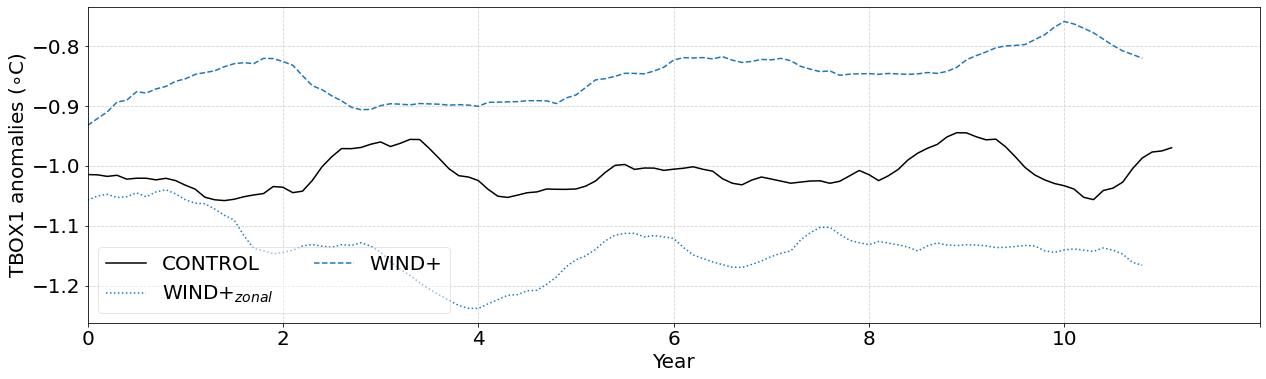

In [33]:
plt.rcParams['font.size'] = 20
fig = plt.figure(figsize = (21, 18))

plt.subplots_adjust(hspace = 0.05)

ax1 = plt.subplot(3, 1, 2)
plt.plot((temp_con).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'k', label = 'CONTROL')
plt.plot((temp_upX).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'C0', linestyle = ':', label = 'WIND+$_{zonal}$')
plt.plot((temp_upY).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'C0', linestyle = '--', label = 'WIND+')

ax1.set_xlim(0,120)

ax1.set_xticklabels(np.arange(0, 12, 2))
ax1.grid(linestyle = '--', color = 'lightgrey')
ax1.set_ylabel('TBOX1 anomalies ($\circ$C)')
ax1.set_xlabel('Year')
a=ax1.legend(ncol = 2, loc = 'lower left',fancybox=True, framealpha=0.5)


figdir = '/home/581/ns3783/Scripts/Figures/Current'
filestr = figdir+'/fig8a_easterlies_series_wind+.png'
plt.savefig(filestr,dpi=600,bbox_inches='tight')


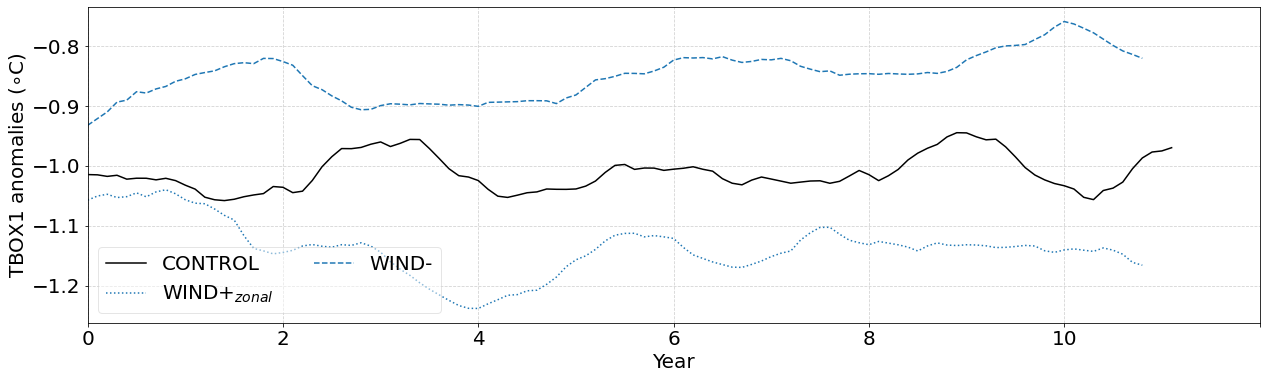

In [32]:
plt.rcParams['font.size'] = 20
fig = plt.figure(figsize = (21, 18))

plt.subplots_adjust(hspace = 0.05)

ax1 = plt.subplot(3, 1, 2)
plt.plot((temp_con).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'k', label = 'CONTROL')
plt.plot((temp_upX).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'C0', linestyle = ':', label = 'WIND+$_{zonal}$')
plt.plot((temp_upY).rolling(time = 12, center = True).mean('time').isel(time=slice(6,None)), 
            color = 'C0', linestyle = '--', label = 'WIND-')

ax1.set_xlim(0,120)

ax1.set_xticklabels(np.arange(0, 12, 2))
ax1.grid(linestyle = '--', color = 'lightgrey')
ax1.set_ylabel('TBOX1 anomalies ($\circ$C)')
ax1.set_xlabel('Year')
a=ax1.legend(ncol = 2, loc = 'lower left',fancybox=True, framealpha=0.5)

figdir = '/home/581/ns3783/Scripts/Figures/Current'
filestr = figdir+'/fig8a_easterlies_series_wind-.png'
plt.savefig(filestr,dpi=600,bbox_inches='tight')